In [1]:
import statsmodels.api as sm
from pylab import rcParams
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import numpy as np
from neo_ls_svm import NeoLSSVM
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [2]:
import torch
import random
import numpy as np


def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True


set_random_seed(42)

import torch.nn as nn

from torch.utils.data import Dataset, DataLoader


In [3]:
# Рассчет S/sigma_delta, которая используется при принятии решении о внедрении методики

def S_sigma_delta(h_fact, h_forecast, delta_k = 1):
    n = len(h_forecast)
    s_delta_k = 0
    S = np.sqrt(n/(n-1) * mean_squared_error(h_fact, h_forecast))
    
    delta = []
    for i in range(n-delta_k):
        dk = (h_fact[i + delta_k] - h_fact[i])
        delta.append(dk)
    mean_delta = np.mean(delta)

    mean_d = np.full(len(delta), mean_delta)
    sigma_delta = np.sqrt(len(delta) / (len(delta) - 1) * mean_squared_error(delta, mean_d))
    
    return S / sigma_delta


# Считываем исходные данные


In [4]:
df = pd.read_excel('data/hydro_and_meteo.xlsx')
df.head()

,DATE,Year,Month,1801,sn_mean,p_mean,h_mean,w_mean,t_mean
0,1985-01-01,1985,1,131.064516,52.171640,27.93,72.177419,1.554839,-32.971855
1,1985-02-01,1985,2,112.642857,67.950149,27.92,75.045536,1.496429,-26.511518
2,1985-03-01,1985,3,116.870968,68.469220,4.30,64.950806,1.396371,-25.670000
3,1985-04-01,1985,4,123.566667,58.936335,13.97,69.945417,1.719583,-11.275625
4,1985-05-01,1985,5,143.290323,35.552824,21.82,61.983871,2.093952,-1.114032


# 1 Модели, основанные только на данных об уровне воды.

## 1.1 Инерционный прогноз

Метод прогнозирования, основанный на предположении о том, что текущие тенденции будут продолжаться в будущем

In [5]:
# Функция рассчета Дельта для инерционного прогноза
def Calculate_Delta(h_fact, delta_k = 1):
    delta = []
    N = len(h_fact)
    for i in range(N-delta_k):
        dk = (h_fact[i + delta_k] - h_fact[i])
        delta.append(dk)
    mean_delta = np.mean(delta)
    return mean_delta

In [6]:
h_tr = df.query('Year <= 2010').reset_index()['1801']
h_test = df.query('Year > 2010').reset_index()['1801']

In [7]:
delta = Calculate_Delta(h_tr)

h_tr_for = list((h_tr.shift(1) + delta)[1:])
h_test_for = list((h_test.shift(1) + delta)[1:])
delta_k = 1


Train period: 
S/sigma :  1.0
RMSE :  175.8753678527438
Test period: 
S/sigma :  1.0
RMSE :  208.58432071728802
R2 :  0.07996943174572269


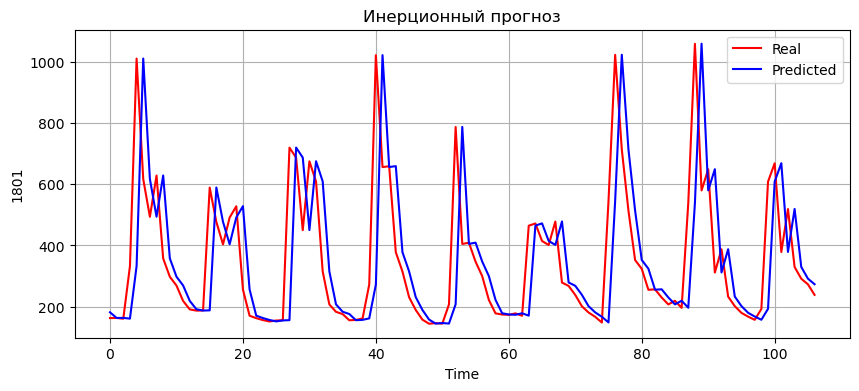

In [8]:
print('Train period: ')
print('S/sigma : ', round(S_sigma_delta(list(h_tr[1:]), h_tr_for), 2))
print('RMSE : ', mean_squared_error(list(h_tr[delta_k:]), h_tr_for, squared = False))

print('Test period: ')
print('S/sigma : ', round(S_sigma_delta(list(h_test[delta_k:]), h_test_for, delta_k = delta_k), 2))
print('RMSE : ', mean_squared_error(h_test[delta_k:], h_test_for, squared = False))
print('R2 : ', r2_score(h_test[delta_k:], h_test_for))

plt.figure(figsize=(10, 4))
#plt.plot(train_data["1801"], color="green", label="Train")
plt.plot(list(h_test[delta_k:]), color="red", label="Real")
plt.plot(h_test_for, color="blue", label="Predicted")

plt.title("Инерционный прогноз")
plt.xlabel("Time")
plt.ylabel("1801")
plt.legend()
plt.grid(True)
plt.show()

## 1.2 SARIMA

In [9]:
df["DATE"] = pd.to_datetime(df["DATE"])
df = df.set_index(["DATE"])
df.index = pd.DatetimeIndex(df.index.values, freq=df.index.inferred_freq)

In [10]:
train_data = df.query('Year <= 2010')[['1801']]
test_data = df.query('Year > 2010')[['1801']]


In [11]:
from pmdarima.arima import auto_arima

stepwise_model = auto_arima(
    train_data,
    start_p=1,
    start_q=1,
    max_p=24,
    max_q=24,
    m=12,
    start_P=0,
    seasonal=True,
    d=1,
    D=1,
    trace=True,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=True,
)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.27 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=3700.252, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=3626.176, Time=0.11 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=3538.611, Time=0.30 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=3616.662, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=3537.162, Time=0.67 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=3566.010, Time=0.14 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=3538.339, Time=0.80 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=3538.498, Time=1.76 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=3537.793, Time=0.86 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=3551.013, Time=0.63 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=inf, Time=1.61 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=3627.229, Time=0.23 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=0.44 sec
 ARIMA(0,1,2)(1,1,1)[12]          

In [12]:
start_data = train_data.index[-1] + pd.DateOffset(months=1)

future_forecast = stepwise_model.predict(start=start_data, n_periods=108)

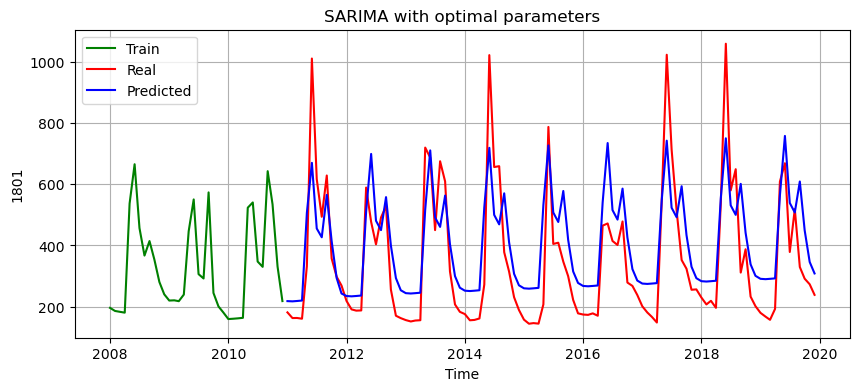

In [13]:
plt.figure(figsize=(10, 4))
plt.plot(train_data["1801"][-36:], color="green", label="Train")
plt.plot(test_data["1801"], color="red", label="Real")
plt.plot(future_forecast, color="blue", label="Predicted")

plt.title("SARIMA with optimal parameters")
plt.xlabel("Time")
plt.ylabel("1801")
plt.legend()
plt.grid(True)
plt.show()

In [14]:

print('Test period: ')
print('S/sigma : ', round(S_sigma_delta(test_data['1801'], future_forecast, delta_k = delta_k), 2))
print('RMSE : ', round(mean_squared_error(test_data['1801'], future_forecast, squared = False), 2))
print('R2 : ', round(r2_score(test_data['1801'], future_forecast), 2))

Test period: 
S/sigma :  0.63
RMSE :  132.06
R2 :  0.63


## 1.3  LS-SVM

In [15]:
data = df[['Year', 'Month', '1801']].copy()
for i in range(11):
    data['1801_sh'+str(i+1)] = data['1801'].shift(i+1)
data.head()


,Year,Month,1801,1801_sh1,1801_sh2,1801_sh3,1801_sh4,1801_sh5,1801_sh6,1801_sh7,1801_sh8,1801_sh9,1801_sh10,1801_sh11
1985-01-01,1985,1,131.064516,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1985-02-01,1985,2,112.642857,131.064516,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1985-03-01,1985,3,116.870968,112.642857,131.064516,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1985-04-01,1985,4,123.566667,116.870968,112.642857,131.064516,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1985-05-01,1985,5,143.290323,123.566667,116.870968,112.642857,131.064516,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
train_data = data.query('Year <= 2010').reset_index()[['1801', '1801_sh1', '1801_sh2', '1801_sh3', '1801_sh4', '1801_sh5', '1801_sh6', '1801_sh7', '1801_sh8', '1801_sh9', '1801_sh10', '1801_sh11']].dropna()
test_data = data.query('Year > 2010').reset_index()[['1801',  '1801_sh1', '1801_sh2', '1801_sh3', '1801_sh4', '1801_sh5', '1801_sh6','1801_sh7', '1801_sh8', '1801_sh9', '1801_sh10', '1801_sh11']]

In [17]:
X_tr = train_data[:-1]
y_tr = train_data[1:]['1801']
X_tst = test_data[:-1]
y_tst = list(test_data[1:]['1801'])

In [18]:
model = NeoLSSVM()
model.fit(X_tr, y_tr)
future_forecast = model.predict(X_tst)


Test period: 
S/sigma :  0.62
RMSE :  130.4
R2 :  0.64


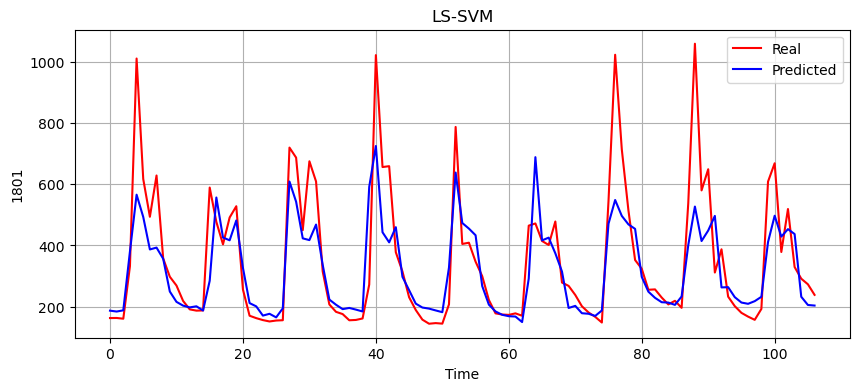

In [19]:
print('Test period: ')
print('S/sigma : ', round(S_sigma_delta(y_tst, future_forecast, delta_k = delta_k), 2))
print('RMSE : ', round(mean_squared_error(y_tst, future_forecast, squared = False), 2))
print('R2 : ', round(r2_score(y_tst, future_forecast), 2))

plt.figure(figsize=(10, 4))
plt.plot(y_tst, color="red", label="Real")
plt.plot(future_forecast, color="blue", label="Predicted")

plt.title("LS-SVM")
plt.xlabel("Time")
plt.ylabel("1801")
plt.legend()
plt.grid(True)
plt.show()



## 1.4 RNN

In [20]:
def simple_display(data, xticks, label=None):
    plt.figure(figsize=(12, 4))
    plt.plot(xticks, data, label=label)
    plt.legend()
    plt.grid()
    plt.show()

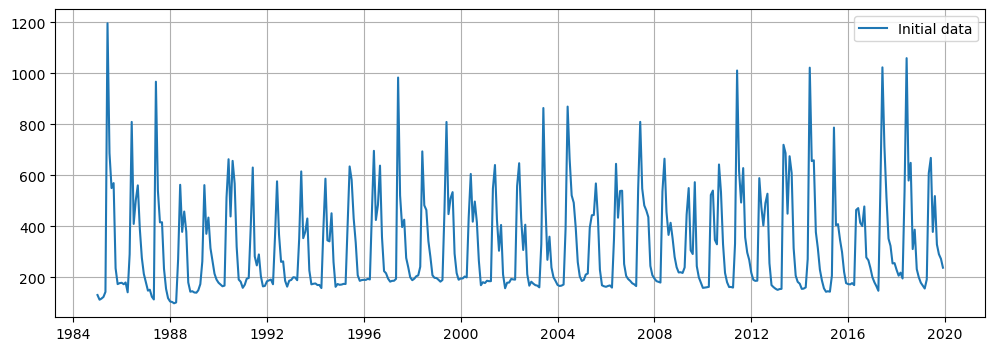

In [21]:
data = df['1801']
df['timestamps'] = range(len(df))
simple_display(data=data, xticks=df.index, label="Initial data")

In [22]:
# Разбиение на train-val-test.
train_start = 0
train_end = 239 - 12

val_start = 240 - 12 # из-за window size небольшой сдвиг
val_end = 420-108-1 -12

test_start = 420-108 -12
test_end = 420

train_data = df.query("(`timestamps` >= @train_start) & (`timestamps` <= @train_end)")[['timestamps','1801']]
val_data = df.query("(`timestamps` >= @val_start) & (`timestamps` <= @val_end)")[['timestamps','1801']]
test_data = df.query("(`timestamps` >= @test_start) & (`timestamps` <= @test_end)")[['timestamps','1801']]

print("Train head and tail:")
display(train_data.iloc[np.r_[0:2, -2:0]])
print("\nVal head and tail:")
display(val_data.iloc[np.r_[0:2, -2:0]])
print("\nTest head and tail:")
display(test_data.iloc[np.r_[0:2, -2:0]])

Train head and tail:


,timestamps,1801
1985-01-01,0,131.064516
1985-02-01,1,112.642857
2003-11-01,226,200.533333
2003-12-01,227,186.580645



Val head and tail:


,timestamps,1801
2004-01-01,228,170.548387
2004-02-01,229,166.517241
2009-11-01,298,200.400000
2009-12-01,299,180.612903



Test head and tail:


,timestamps,1801
2010-01-01,300,159.064516
2010-02-01,301,160.142857
2019-11-01,418,272.800000
2019-12-01,419,238.193548


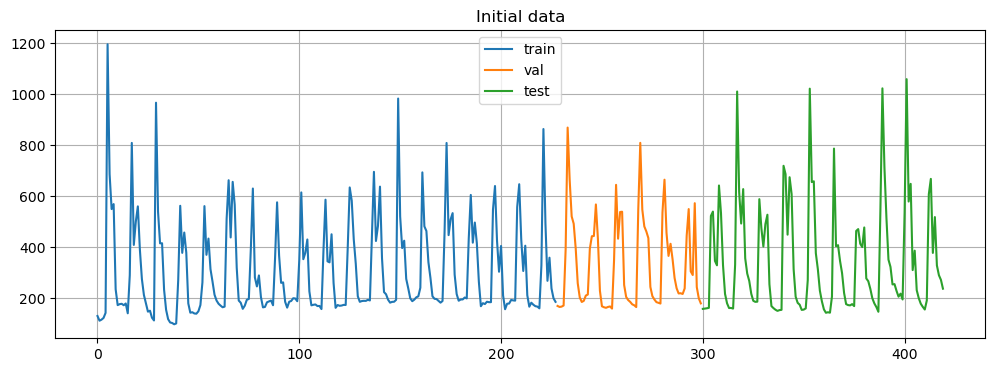

In [23]:
split = {"train": {}, "val": {}, "test": {}}

for part, data_part in zip(split, [train_data, val_data, test_data]):
    split[part]["timestamps"] = data_part["timestamps"]
    split[part]["data"] = data_part["1801"].values

def initial_data_display(split):
    plt.figure(figsize=(12, 4))
    for part in split:
        plt.plot(split[part]["timestamps"], split[part]["data"], label=part)
    plt.title("Initial data")
    plt.legend()
    plt.grid()
    plt.show()


initial_data_display(split)

In [24]:
# Предобработка данных.

from sklearn.linear_model import LinearRegression


class TimeSeriesTransform:
    def __init__(self, apply_log=False):
        self.slope = None
        self.apply_log = apply_log

    def fit(self, train_data: np.ndarray):
        data = train_data
        #print(data)
        if self.apply_log:
            data = np.log(data + 15)  # to avoid log(0)

        x = np.arange(len(data))
        x_centered = x - x.mean()

        data_centered = data - data.mean()

        reg = LinearRegression(fit_intercept=False).fit(
            x_centered.reshape(-1, 1), data_centered.reshape(-1, 1)
        )

        self.slope = reg.coef_[0]

        return self

    def transform(self, data: np.ndarray, window_size: int):
        if self.slope is None:
            raise ValueError("call fit before transform")

        if self.apply_log:
            data = np.log(data + 15)  # to avoid log(0)

        x = np.arange(len(data))
        x_centered = x - x.mean()
        trend = self.slope * x_centered

        anchor_value = data[window_size]
        data_centered = data - data.mean()
        data_detrended = data_centered - trend
        return anchor_value, data_detrended

    def inverse_transform(self, anchor_value: float, data_detrended: np.ndarray):
        if self.slope is None:
            raise ValueError("call fit before inverse_transform")

        x = np.arange(len(data_detrended))
        x_centered = x - x.mean()
        trend = self.slope * x_centered

        data = data_detrended + trend
        data = data - data[0] + anchor_value
        if self.apply_log:
            data = np.exp(data) - 15
        return data


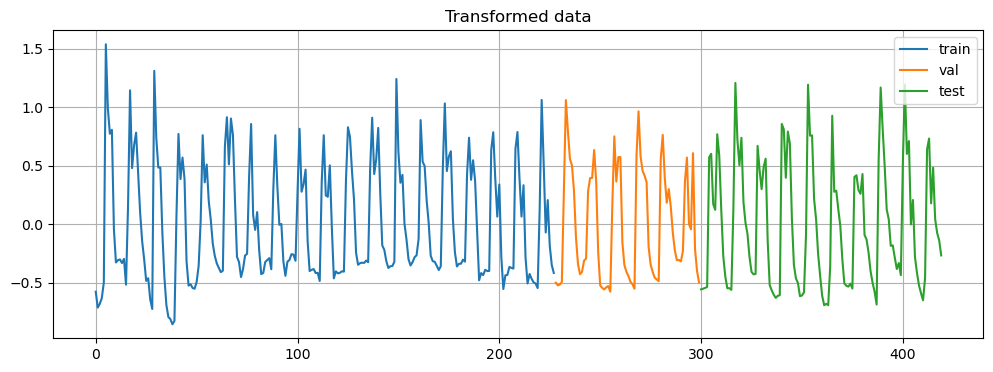

In [25]:
window_size = 12

split["train"]["transform"] = TimeSeriesTransform(apply_log=True)

split["train"]["transform"].fit(split["train"]["data"])

for part in split:
    split[part]["anchor_value"], split[part]["data_transformed"] = split["train"][
        "transform"
    ].transform(split[part]["data"], window_size=window_size)

def transformed_data_display(split):
    plt.figure(figsize=(12, 4))
    for part in split:
        plt.plot(split[part]["timestamps"], split[part]["data_transformed"], label=part)
    plt.title("Transformed data")
    plt.legend()
    plt.grid()
    plt.show()


transformed_data_display(split)

In [26]:

class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length):
        super().__init__()
        self.seq_length = seq_length
        self.data = torch.from_numpy(data).float()

    def __getitem__(self, idx):
        # seq_len elements input
        x = self.data[idx : (idx + self.seq_length)].view(-1, 1)
        # one element output
        y = self.data[idx + self.seq_length]
        return x, y

    def __len__(self):
        return len(self.data) - self.seq_length

from torch.utils.data import DataLoader

for part in split:
    split[part]["dataset"] = TimeSeriesDataset(
        data=split[part]["data_transformed"], seq_length=window_size
    )

    shuffle = True if part == "train" else False

    split[part]["dataloader"] = DataLoader(
        dataset=split[part]["dataset"], batch_size=16, shuffle=shuffle
    )

In [27]:

class TimeSeriesPredictor(nn.Module):
    def __init__(self, input_size=1, hidden_size=20):
        # hidden_size it is number of hidden neurons
        super().__init__()
        self.rnn = nn.RNN(
            input_size=input_size, hidden_size=hidden_size, batch_first=True
        )
        # Predict only one value
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x shape: [b_s, seq_len, input_size]  b_s <= batch_size
        out, h = self.rnn(x)  # [b_s, seq_len, hidden_size], [1, b_s, hidden_size]
        y = self.fc(h)  # [1, b_s, 1]
        y = y.flatten()  # [b_s]
        return y

In [28]:
x, y = next(iter(split["train"]["dataloader"]))
print(x.shape)
model = TimeSeriesPredictor()
out = model(x)

print(f"Model output size: {out.shape} (bach_size x out_dim)")

torch.Size([16, 12, 1])
Model output size: torch.Size([16]) (bach_size x out_dim)


In [29]:
def forced_predict(model, split, part):
    y_true = []
    y_pred = []
    model.eval()
    dataset = split[part]["dataset"]
    with torch.no_grad():
        for x, y in dataset:
            out = model(x)
            y_true.append(y.item())
            y_pred.append(out.item())
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    transform = split["train"]["transform"]
    y_true = transform.inverse_transform(split[part]["anchor_value"], y_true)
    y_pred = transform.inverse_transform(split[part]["anchor_value"], y_pred)

    return y_true, y_pred

In [30]:
import lightning as L
from torchmetrics import MetricCollection
from torchmetrics.regression import MeanSquaredError


class TimeSeriesPipeline(L.LightningModule):
    def __init__(
        self,
        model,
        exp_name="RNN_hydro",
        criterion=nn.MSELoss(),
        optimizer_class=torch.optim.Adam,
    ):
        super().__init__()
        self.model = model
        self.criterion = criterion
        self.optimizer_class = optimizer_class
        metrics = MetricCollection([MeanSquaredError()])
        self.train_metrics = metrics.clone(postfix="/train")
        self.valid_metrics = metrics.clone(postfix="/val")

    def configure_optimizers(self):
        optimizer = self.optimizer_class(self.model.parameters())
        return optimizer

    def training_step(self, batch, batch_idx):
        x, y = batch
        out = self.model(x)
        loss = self.criterion(out, y)

        self.log("Loss/train", loss, prog_bar=True)
        self.train_metrics.update(out, y)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        out = self.model(x)
        loss = self.criterion(out, y)
        self.log("Loss/val", loss, prog_bar=True)
        self.valid_metrics.update(out, y)

    def on_training_epoch_end(self):
        train_metrics = self.train_metrics.compute()
        self.log_dict(train_metrics)
        self.train_metrics.reset()

    def on_validation_epoch_end(self):
        valid_metrics = self.valid_metrics.compute()
        self.log_dict(valid_metrics)
        self.valid_metrics.reset()

In [31]:
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger

L.seed_everything(42)

checkpoint_callback = ModelCheckpoint(
    monitor="MeanSquaredError/val", mode="min", filename="best"
)

exp_name = f"rnn_hydro"
trainer = Trainer(
    max_epochs=170,
    logger=TensorBoardLogger(save_dir=f"logs/time_series_prediction", name=exp_name),
    num_sanity_val_steps=1,
    callbacks=[checkpoint_callback],
    enable_progress_bar=True,
)

model = TimeSeriesPredictor()

pipeline = TimeSeriesPipeline(
    model=model,
    optimizer_class=torch.optim.Adam,
)

trainer.fit(
    model=pipeline,
    train_dataloaders=split["train"]["dataloader"],
    val_dataloaders=split["val"]["dataloader"],
)

Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type                | Params | Mode 
--------------------------------------------------------------
0 | model         | TimeSeriesPredictor | 481    | train
1 | criterion     | MSELoss             | 0      | train
2 | train_metrics | MetricCollection    | 0      | train
3 | valid_metrics | MetricCollection    | 0      | train
--------------------------------------------------------------
481       Trainable params
0         Non-trainable params
481       Total params
0.002     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\black\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\Users\black\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\Users\black\anaconda3\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (14) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=170` reached.


In [32]:
base_path = f"logs/time_series_prediction/{exp_name}"
last_version = sorted(os.listdir(base_path))[-1]
log_path = f"{base_path}/{last_version}"

ckpt_path = f"{log_path}/checkpoints/best.ckpt"
checkpoint = torch.load(ckpt_path)

print(f"Checkpoint has been loaded from {ckpt_path}")
print(f"Best model has been saved on the {checkpoint['epoch']} epoch")

state_dict = {}
for key in checkpoint["state_dict"].keys():
    key_new = key.lstrip("model.")
    state_dict[key_new] = checkpoint["state_dict"][key]

model = TimeSeriesPredictor()

model.load_state_dict(state_dict)

Checkpoint has been loaded from logs/time_series_prediction/rnn_hydro/version_0/checkpoints/best.ckpt
Best model has been saved on the 127 epoch


C:\Users\black\AppData\Local\Temp\ipykernel_24628\2982367243.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path)


<All keys matched successfully>

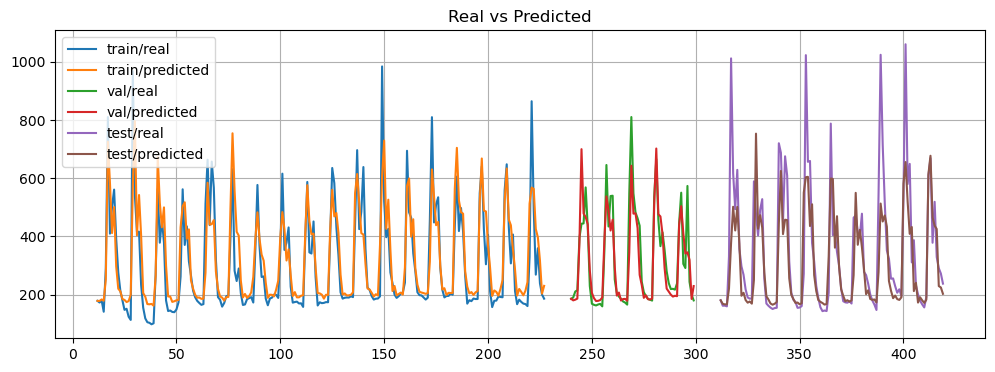

In [33]:
for part in split:
    if part in ("train", "val"):
        y_true, y_pred = forced_predict(model, split, part)

    if part == "test":
        y_true, y_pred = forced_predict(model, split, part)
        #y_pred = rolling_predict(model, split, part, forecast_horizon=len(y_true))

    split[part]["y_true"] = y_true
    split[part]["y_pred"] = y_pred



def display_pred_with_rolling_test(split):
    plt.figure(figsize=(12, 4))
    for part in split:
        timestamps = split[part]["timestamps"][window_size:]
        real_data = split[part]["y_true"]
        pred_data = split[part]["y_pred"]

        if part in ("train", "val"):

            plt.plot(timestamps, real_data, label=f"{part}/real")
            plt.plot(timestamps, pred_data, label=f"{part}/predicted")

        if part == "test":
            plt.plot(timestamps, real_data, label=f"{part}/real")

            future_timestamps = range(timestamps.iloc[0], timestamps.iloc[0] + len(pred_data))
            plt.plot(future_timestamps, pred_data, label=f"{part}/predicted")

    plt.title("Real vs Predicted")
    plt.legend()
    plt.grid()
    plt.show()



display_pred_with_rolling_test(split)

In [34]:
for part in split:
    part_rmse = mean_squared_error(
        y_true=split[part]["y_true"], y_pred=split[part]["y_pred"], squared=False
    )
    s_sigm =  S_sigma_delta(split[part]["y_true"], split[part]["y_pred"], delta_k = 1)
    print(f"{part:<5} S/sigma: {s_sigm:.2f}")
    print(f"{part:<5} RMSE: {part_rmse:.2f}")
    r2 = r2_score(y_true = split[part]["y_true"], y_pred = split[part]["y_pred"])
    print(f"{part:<5} R2: {r2:.2f} ")

train S/sigma: 0.52
train RMSE: 87.52
train R2: 0.74 
val   S/sigma: 0.52
val   RMSE: 74.09
val   R2: 0.79 
test  S/sigma: 0.66
test  RMSE: 138.01
test  R2: 0.60 


## 1.5 GRU

In [35]:
class TimeSeriesPredictorGRU(nn.Module):
    def __init__(self, input_size=1, hidden_size=25, layer_dim = 1):
        # hidden_size it is number of hidden neurons
        super().__init__()
        self.layer_dim = layer_dim
        self.hidden_dim = hidden_size
        self.gru = nn.GRU(
            input_size, hidden_size, layer_dim,  batch_first=True,
        )
        # Predict only one value
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        #print(x.shape)
        out, h = self.gru(x)
        #print(out.shape)
        if out.dim() == 3:
            out = out[:, -1, :]
        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)
        #print(out.shape)
        out = out.flatten()
        return out

In [36]:
x, y = next(iter(split["train"]["dataloader"]))
model = TimeSeriesPredictorGRU()
out = model(x)

print(f"Model output size: {out.shape} (bach_size x out_dim)")


Model output size: torch.Size([16]) (bach_size x out_dim)


In [37]:

L.seed_everything(42)

checkpoint_callback = ModelCheckpoint(
    monitor="MeanSquaredError/val", mode="min", filename="best"
)

exp_name = f"GRU_hydro"
trainer = Trainer(
    max_epochs=250,
    logger=TensorBoardLogger(save_dir=f"logs/time_series_prediction", name=exp_name),
    num_sanity_val_steps=1,
    callbacks=[checkpoint_callback],
    enable_progress_bar=True,
)

model = TimeSeriesPredictorGRU()

pipeline = TimeSeriesPipeline(
    model=model,
    optimizer_class=torch.optim.Adam,
)

trainer.fit(
    model=pipeline,
    train_dataloaders=split["train"]["dataloader"],
    val_dataloaders=split["val"]["dataloader"],
)

Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type                   | Params | Mode 
-----------------------------------------------------------------
0 | model         | TimeSeriesPredictorGRU | 2.1 K  | train
1 | criterion     | MSELoss                | 0      | train
2 | train_metrics | MetricCollection       | 0      | train
3 | valid_metrics | MetricCollection       | 0      | train
-----------------------------------------------------------------
2.1 K     Trainable params
0         Non-trainable params
2.1 K     Total params
0.009     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\black\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\Users\black\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\Users\black\anaconda3\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (14) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=250` reached.


In [38]:
base_path = f"logs/time_series_prediction/{exp_name}"
last_version = sorted(os.listdir(base_path))[-1]
log_path = f"{base_path}/{last_version}"

ckpt_path = f"{log_path}/checkpoints/best.ckpt"
checkpoint = torch.load(ckpt_path)

print(f"Checkpoint has been loaded from {ckpt_path}")
print(f"Best model has been saved on the {checkpoint['epoch']} epoch")

state_dict = {}
for key in checkpoint["state_dict"].keys():
    key_new = key.lstrip("model.")
    state_dict[key_new] = checkpoint["state_dict"][key]

model = TimeSeriesPredictorGRU()

model.load_state_dict(state_dict)

Checkpoint has been loaded from logs/time_series_prediction/GRU_hydro/version_0/checkpoints/best.ckpt
Best model has been saved on the 152 epoch


C:\Users\black\AppData\Local\Temp\ipykernel_24628\2012957514.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path)


<All keys matched successfully>

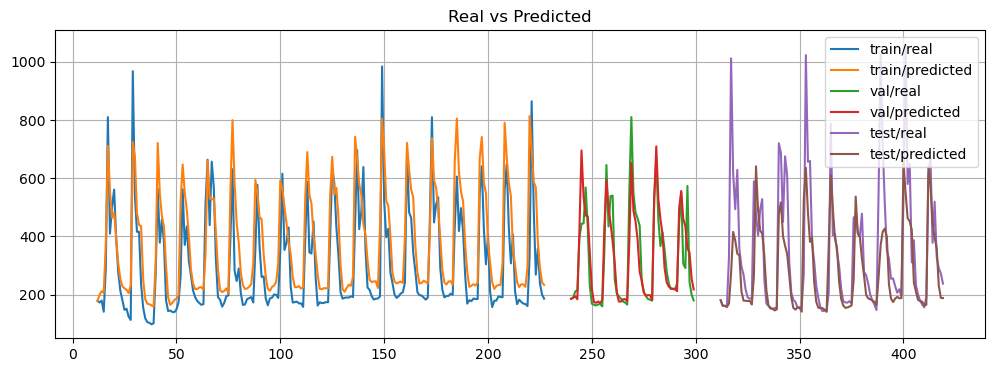

In [39]:
def forced_predict(model, split, part):
    y_true = []
    y_pred = []
    model.eval()
    dataset = split[part]["dataset"]
    with torch.no_grad():
        for x, y in dataset:
            #print(x.shape)
            out = model(x.unsqueeze(0))
            y_true.append(y.item())
            #print(out.shape)
            y_pred.append(out.squeeze().tolist())
            
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    transform = split["train"]["transform"]
    y_true = transform.inverse_transform(split[part]["anchor_value"], y_true)
    y_pred = transform.inverse_transform(split[part]["anchor_value"], y_pred)

    return y_true, y_pred

for part in split:
    if part in ("train", "val"):
        
        y_true, y_pred = forced_predict(model, split, part)

    if part == "test":
        y_true, y_pred = forced_predict(model, split, part)
        #y_pred = rolling_predict(model, split, part, forecast_horizon=len(y_true))

    split[part]["y_true"] = y_true
    split[part]["y_pred"] = y_pred
    


display_pred_with_rolling_test(split)

In [40]:
for part in split:
    part_rmse = mean_squared_error(
        y_true=split[part]["y_true"], y_pred=split[part]["y_pred"], squared=False
    )
    s_sigm =  S_sigma_delta(split[part]["y_true"], split[part]["y_pred"], delta_k = 1)
    print(f"{part:<5} S/sigma: {s_sigm:.2f}")
    print(f"{part:<5} RMSE: {part_rmse:.2f}")
    r2 = r2_score(y_true = split[part]["y_true"], y_pred = split[part]["y_pred"])
    print(f"{part:<5} R2: {r2:.2f} ")

train S/sigma: 0.65
train RMSE: 110.20
train R2: 0.59 
val   S/sigma: 0.55
val   RMSE: 78.46
val   R2: 0.76 
test  S/sigma: 0.75
test  RMSE: 157.11
test  R2: 0.48 


# 2 Модели, основанные на гидрологических и метеорологических данных

In [49]:
df = pd.read_excel('data/hydro_and_meteo.xlsx')
df.head()

,DATE,Year,Month,1801,sn_mean,p_mean,h_mean,w_mean,t_mean
0,1985-01-01,1985,1,131.064516,52.171640,27.93,72.177419,1.554839,-32.971855
1,1985-02-01,1985,2,112.642857,67.950149,27.92,75.045536,1.496429,-26.511518
2,1985-03-01,1985,3,116.870968,68.469220,4.30,64.950806,1.396371,-25.670000
3,1985-04-01,1985,4,123.566667,58.936335,13.97,69.945417,1.719583,-11.275625
4,1985-05-01,1985,5,143.290323,35.552824,21.82,61.983871,2.093952,-1.114032


## 2.1 SARIMAX

In [50]:
df["DATE"] = pd.to_datetime(df["DATE"])
df = df.set_index(["DATE"])
df.index = pd.DatetimeIndex(df.index.values, freq=df.index.inferred_freq)

train_data = df.query('Year <= 2010')
test_data = df.query('Year > 2010')

In [51]:
from pmdarima.arima import auto_arima
#from pyramid.arima import auto_arima

stepwise_model = auto_arima(
    y = train_data["1801"],
    X = train_data[[ 'sn_mean']],
    start_p=1,
    start_q=1,
    max_p=10,
    max_q=10,
    m=12,
    start_P=0,
    seasonal=True,
    d=1,
    D=1,
    trace=True,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=True,
    maxiter=75,# default 50
    
)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.36 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=3679.311, Time=0.09 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=3604.898, Time=0.28 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=3527.509, Time=0.24 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=3608.565, Time=0.14 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=3526.884, Time=0.43 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=3556.459, Time=0.25 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=3528.246, Time=1.08 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=3528.436, Time=1.52 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=3527.298, Time=0.62 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=3541.492, Time=0.58 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=inf, Time=2.36 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=3602.264, Time=0.32 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=0.50 sec
 ARIMA(0,1,2)(1,1,1)[12]          

In [52]:
start_data = train_data.index[-1] + pd.DateOffset(months=1)
future_forecast = stepwise_model.predict(X = test_data[['sn_mean']], start=start_data, n_periods=108)


Test period: 
S/sigma :  0.58
RMSE :  120.92
R2 :  0.69


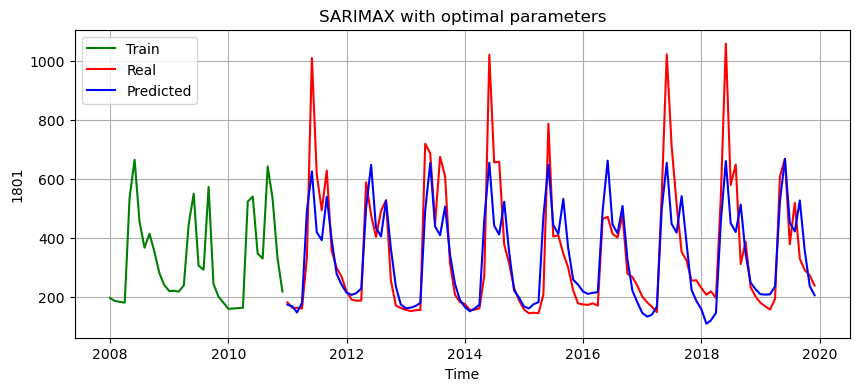

In [53]:
print('Test period: ')
print('S/sigma : ', round(S_sigma_delta(test_data['1801'], future_forecast, delta_k = delta_k), 2))
print('RMSE : ', round(mean_squared_error(test_data['1801'], future_forecast, squared = False), 2))
print('R2 : ', round(r2_score(test_data['1801'], future_forecast), 2))

plt.figure(figsize=(10, 4))
plt.plot(train_data["1801"][-36:], color="green", label="Train")
plt.plot(test_data["1801"], color="red", label="Real")
plt.plot(future_forecast, color="blue", label="Predicted")

plt.title("SARIMAX with optimal parameters")
plt.xlabel("Time")
plt.ylabel("1801")
plt.legend()
plt.grid(True)
plt.show()

## 2.2 LS-SVM


In [54]:
data = df[['Year', 'Month', '1801', 'p_mean','t_mean','w_mean', 'sn_mean', 'h_mean']].copy()
for i in range(11):
    data['1801_sh'+str(i+1)] = data['1801'].shift(i+1)
    if i < 5:
        data['p_mean_sh'+str(i+1)] = data['p_mean'].shift(i+1)
        data['t_mean_sh'+str(i+1)] = data['t_mean'].shift(i+1)
        data['w_mean_sh'+str(i+1)] = data['w_mean'].shift(i+1)
        data['sn_mean_sh'+str(i+1)] = data['sn_mean'].shift(i+1)
        data['h_mean_sh'+str(i+1)] = data['h_mean'].shift(i+1)
data.head()

,Year,Month,1801,p_mean,t_mean,w_mean,sn_mean,h_mean,1801_sh1,p_mean_sh1,...,t_mean_sh5,w_mean_sh5,sn_mean_sh5,h_mean_sh5,1801_sh6,1801_sh7,1801_sh8,1801_sh9,1801_sh10,1801_sh11
1985-01-01,1985,1,131.064516,27.93,-32.971855,1.554839,52.171640,72.177419,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1985-02-01,1985,2,112.642857,27.92,-26.511518,1.496429,67.950149,75.045536,131.064516,27.93,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1985-03-01,1985,3,116.870968,4.30,-25.670000,1.396371,68.469220,64.950806,112.642857,27.92,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1985-04-01,1985,4,123.566667,13.97,-11.275625,1.719583,58.936335,69.945417,116.870968,4.30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1985-05-01,1985,5,143.290323,21.82,-1.114032,2.093952,35.552824,61.983871,123.566667,13.97,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
train_data = data.query('Year <= 2010').reset_index().dropna()
test_data = data.query('Year > 2010').reset_index()

In [56]:
X_tr = train_data[:-1][['1801', '1801_sh1', '1801_sh2', '1801_sh3', '1801_sh4', '1801_sh5',
                        '1801_sh6', '1801_sh7', '1801_sh8', '1801_sh9', '1801_sh10', '1801_sh11',
                        'p_mean', 'p_mean_sh1','p_mean_sh2','p_mean_sh3','p_mean_sh4', 'p_mean_sh5',
                        't_mean','t_mean_sh1','t_mean_sh2','t_mean_sh3','t_mean_sh4', 't_mean_sh5',
                        'w_mean','w_mean_sh1','w_mean_sh2','w_mean_sh3','w_mean_sh4', 'w_mean_sh5',
                        'sn_mean','sn_mean_sh1','sn_mean_sh2','sn_mean_sh3','sn_mean_sh4', 'sn_mean_sh5',
                       'h_mean','h_mean_sh1','h_mean_sh2','h_mean_sh3','h_mean_sh4', 'h_mean_sh5']]
y_tr = list(train_data[1:]['1801'])
X_tst = test_data[:-1][['1801', '1801_sh1', '1801_sh2', '1801_sh3', '1801_sh4', '1801_sh5',
                        '1801_sh6', '1801_sh7', '1801_sh8', '1801_sh9', '1801_sh10', '1801_sh11',
                        'p_mean', 'p_mean_sh1','p_mean_sh2','p_mean_sh3','p_mean_sh4', 'p_mean_sh5',
                        't_mean','t_mean_sh1','t_mean_sh2','t_mean_sh3','t_mean_sh4', 't_mean_sh5',
                        'w_mean','w_mean_sh1','w_mean_sh2','w_mean_sh3','w_mean_sh4', 'w_mean_sh5',
                        'sn_mean','sn_mean_sh1','sn_mean_sh2','sn_mean_sh3','sn_mean_sh4', 'sn_mean_sh5',
                       'h_mean','h_mean_sh1','h_mean_sh2','h_mean_sh3','h_mean_sh4', 'h_mean_sh5']]
y_tst = list(test_data[1:]['1801'])

In [57]:
model = NeoLSSVM()
model.fit(X_tr, y_tr)

tr_forecast = model.predict(X_tr)
future_forecast = model.predict(X_tst)



Test period: 
S/sigma :  0.51
RMSE :  107.68
R2 :  0.75


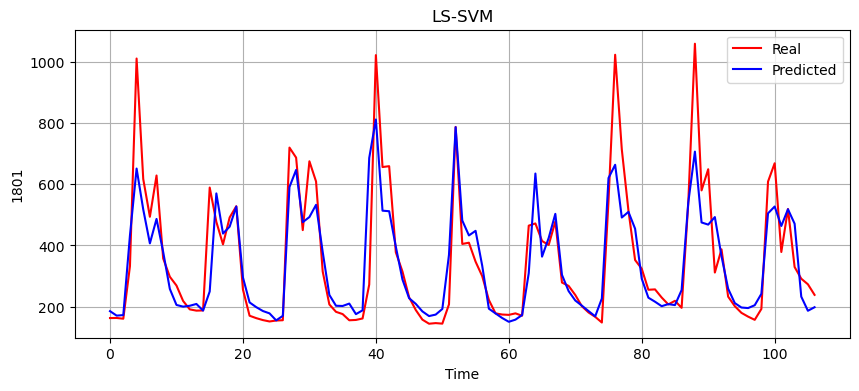

In [58]:
print('Test period: ')
print('S/sigma : ', round(S_sigma_delta(y_tst, future_forecast, delta_k = delta_k), 2))
print('RMSE : ', round(mean_squared_error(y_tst, future_forecast, squared = False), 2))
print('R2 : ', round(r2_score(y_tst, future_forecast), 2))

plt.figure(figsize=(10, 4))
plt.plot(y_tst, color="red", label="Real")
plt.plot(future_forecast, color="blue", label="Predicted")

plt.title("LS-SVM")
plt.xlabel("Time")
plt.ylabel("1801")
plt.legend()
plt.grid(True)
plt.show()


## 2.3 LSTM

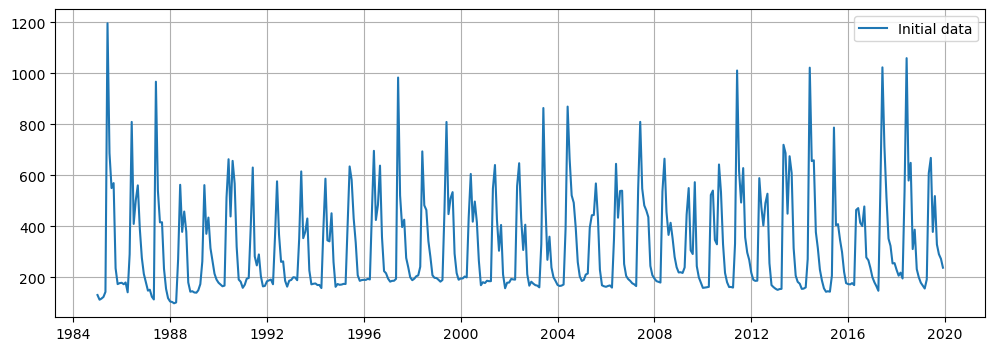

In [59]:
data = df['1801']
df = df[['1801', 't_mean', 'h_mean', 'p_mean','t_mean','w_mean', 'sn_mean']]
df['timestamps'] = range(len(df))
simple_display(data=data, xticks=df.index, label="Initial data")

In [60]:
train_start = 0
train_end = 239-12

val_start = 240-12
val_end = 420-108-1-12

test_start = 420-108-12 # нужен год
test_end = 420

train_data = df.query("(`timestamps` >= @train_start) & (`timestamps` <= @train_end)")
val_data = df.query("(`timestamps` >= @val_start) & (`timestamps` <= @val_end)")
test_data = df.query("(`timestamps` >= @test_start) & (`timestamps` <= @test_end)")

print("Train head and tail:")
display(train_data.iloc[np.r_[0:2, -2:0]])
print("\nVal head and tail:")
display(val_data.iloc[np.r_[0:2, -2:0]])
print("\nTest head and tail:")
display(test_data.iloc[np.r_[0:2, -2:0]])

Train head and tail:


,1801,t_mean,h_mean,p_mean,t_mean,w_mean,sn_mean,timestamps
1985-01-01,131.064516,-32.971855,72.177419,27.93,-32.971855,1.554839,52.171640,0
1985-02-01,112.642857,-26.511518,75.045536,27.92,-26.511518,1.496429,67.950149,1
2003-11-01,200.533333,-24.444542,78.186667,56.55,-24.444542,1.730833,41.294444,226
2003-12-01,186.580645,-33.502984,75.025806,20.73,-33.502984,0.912097,45.622581,227



Val head and tail:


,1801,t_mean,h_mean,p_mean,t_mean,w_mean,sn_mean,timestamps
2004-01-01,170.548387,-35.384194,75.530242,11.26,-35.384194,0.517742,53.798925,228
2004-02-01,166.517241,-33.889569,73.461207,12.47,-33.889569,0.984914,57.467816,229
2009-11-01,200.400000,-28.872000,78.597500,28.98,-28.872000,1.028750,28.484444,298
2009-12-01,180.612903,-30.156169,77.535081,24.69,-30.156169,1.249597,38.400000,299



Test head and tail:


,1801,t_mean,h_mean,p_mean,t_mean,w_mean,sn_mean,timestamps
2010-01-01,159.064516,-35.710766,75.206048,10.43,-35.710766,1.039516,45.161290,300
2010-02-01,160.142857,-32.884241,74.027232,15.53,-32.884241,1.344196,48.572619,301
2019-11-01,272.800000,-18.589083,78.825833,35.87,-18.589083,1.555417,36.213333,418
2019-12-01,238.193548,-33.234032,67.201210,21.09,-33.234032,1.211290,45.970968,419


In [62]:
print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

split = {"train": {}, "val": {}, "test": {}}

for part, data_part in zip(split, [train_data, val_data, test_data]):
    split[part]["timestamps"] = data_part.index
    split[part]["data"] = data_part.values

(228, 8)
(72, 8)
(120, 8)


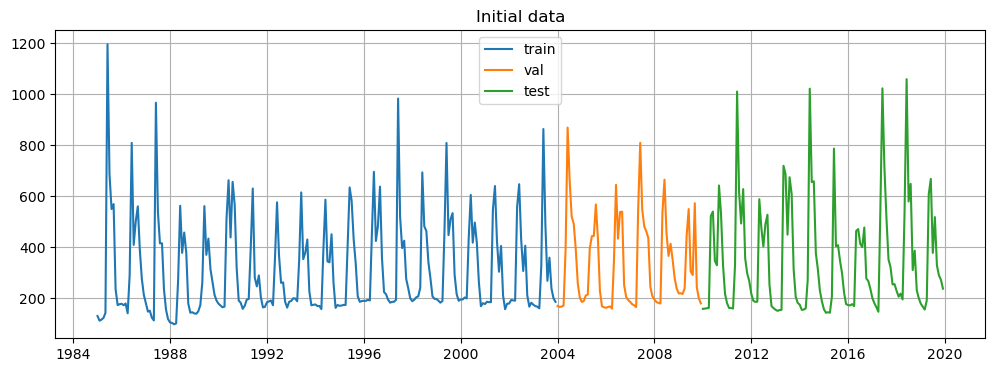

In [64]:
def initial_data_display(split):
    plt.figure(figsize=(12, 4))
    for part in split:
        plt.plot(split[part]["timestamps"], split[part]["data"][:, 0], label=part)
    plt.title("Initial data")
    plt.legend()
    plt.grid()
    plt.show()
    
initial_data_display(split)

In [65]:
from sklearn.preprocessing import StandardScaler

class TimeSeriesTransform:
    def __init__(self, apply_log=False):
        self.slope = None
        self.apply_log = apply_log
        self.mean = None
        self.std = None

    def fit(self, train_data: np.ndarray):
        data = train_data
        if self.apply_log:
            data = np.log(data + 1)  # to avoid log(0)

        x = np.arange(len(data))
        x_centered = x - x.mean()

        self.mean = data.mean(axis=0)
        self.std = data.std(axis=0)

        data_centered = (data - self.mean) / self.std

        slopes = []
        for i in range(data_centered.shape[1]):
            reg = LinearRegression(fit_intercept=False).fit(
                x_centered.reshape(-1, 1), data_centered[:, i].reshape(-1, 1)
            )
            slopes.append(reg.coef_[0])

        self.slope = slopes

        return self

    def transform(self, data: np.ndarray, window_size: int):
        if self.slope is None:
            raise ValueError("call fit before transform")

        if self.apply_log:
            data = np.log(data + 1)  # to avoid log(0)

        x = np.arange(len(data))
        x_centered = x - x.mean()
        trend = self.slope * x_centered

        anchor_value = data[window_size]
        data_centered = (data - self.mean) / self.std
        data_detrended = data_centered - trend.T
        return anchor_value, data_detrended

    def inverse_transform(self, anchor_value: float, data_detrended: np.ndarray):
        if self.slope is None:
            raise ValueError("call fit before inverse_transform")
        x = np.arange(len(data_detrended))
        x_centered = x - x.mean()
        trend = self.slope * x_centered

        trend = trend.T
        data = np.squeeze(data_detrended) + trend
        data = data * self.std + self.mean
        

        data += anchor_value - data[0]
        if self.apply_log:
            data = np.exp(data) - 1
        return data

In [66]:
window_size = 12

split["train"]["transform"] = TimeSeriesTransform(apply_log=False)

split["train"]["transform"].fit(split["train"]["data"])

for part in split:
    split[part]["anchor_value"], split[part]["data_transformed"] = split["train"][
        "transform"
    ].transform(split[part]["data"], window_size=window_size)


In [68]:
def transformed_data_display(split):
    for i in range(5):
        plt.figure(figsize=(12, 4))
        for part in split:
            plt.plot(
                split[part]["timestamps"],
                split[part]["data_transformed"][:, i],
                label=part,
            )
        plt.title("Transformed data "+ str(i))
        plt.legend()
        plt.grid()
        plt.show()


#transformed_data_display(split)

In [69]:

class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length):
        super().__init__()
        self.seq_length = seq_length
        self.data = torch.from_numpy(data).float()

    def __getitem__(self, idx):
        # seq_len elements input
        x = self.data[idx : (idx + self.seq_length)].view(-1, 8) #
        # one element output
        y = self.data[idx + self.seq_length]
        #print(y)
        return x, y

    def __len__(self):
        return len(self.data) - self.seq_length

In [70]:
for part in split:
    split[part]["dataset"] = TimeSeriesDataset(
        data=split[part]["data_transformed"], seq_length=window_size
    )

    shuffle = True if part == "train" else False

    split[part]["dataloader"] = DataLoader(
        dataset=split[part]["dataset"], batch_size=16, shuffle=shuffle
    )

In [71]:
x, y = next(iter(split["train"]["dataloader"]))

print(f"one batch input shape:   {x.shape}")
print(f"one batch output shape:  {y.shape}")
print(f"number of train batches: {len(split['train']['dataloader'])}")

one batch input shape:   torch.Size([16, 12, 8])
one batch output shape:  torch.Size([16, 8])
number of train batches: 14


In [91]:

class TimeSeriesPredictor(nn.Module):
    def __init__(self, input_size=8, hidden_size=50): 
        # hidden_size it is number of hidden neurons
        super().__init__()
        self.rnn = nn.LSTM(
            input_size=input_size, hidden_size=hidden_size, num_layers = 1,  batch_first=True
        )
        # Predict five values
        self.fc = nn.Linear(hidden_size,8)

    def forward(self, x):
        # x shape: [b_s, seq_len, input_size]  b_s <= batch_size
        #print(self.rnn(x))
        out, (h, c) = self.rnn(x)  # [b_s, seq_len, hidden_size], [1, b_s, hidden_size]

        y = self.fc(h[-1])  # [1, b_s, 5]
        y = y.view(-1, 8)
        #y = y.flatten()  # [b_s]
        return y

In [92]:
model = TimeSeriesPredictor()
out = model(x)

print(f"Model output size: {out.shape} (bach_size x out_dim)")

Model output size: torch.Size([16, 8]) (bach_size x out_dim)


In [93]:
def forced_predict(model, split, part):
    y_true = []
    y_pred = []
    model.eval()
    dataset = split[part]["dataset"]
    with torch.no_grad():
        for x, y in dataset:
            out = model(x)
            y_true.append(y.tolist())
            y_pred.append(out.tolist())
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    transform = split["train"]["transform"]
    y_true = transform.inverse_transform(split[part]["anchor_value"], y_true)
    y_pred = transform.inverse_transform(split[part]["anchor_value"], y_pred)

    return y_true, y_pred

In [94]:
from datetime import timedelta
from dateutil.relativedelta import relativedelta

def display_pred_with_rolling_test(
    split, show_only_target=False, post_test=False, dataset=df
):
    for i in range(5):
        plt.figure(figsize=(12, 4))
        if show_only_target:
            i = 0  # show Close column
        for part in split:
            timestamps = split[part]["timestamps"][window_size:]
            real_data = split[part]["y_true"][:, i]
            pred_data = split[part]["y_pred"][:, i]

            if part in ("train", "val"):

                plt.plot(timestamps, real_data, label=f"{part}/real")
                plt.plot(timestamps, pred_data, label=f"{part}/predicted")

            if part == "test":
                plt.plot(timestamps, real_data, label=f"{part}/real")
                # difference from the lecture code
                future_timestamps =  [timestamps[0] + relativedelta(months=i) for i in range(len(pred_data))]
                plt.plot(future_timestamps, pred_data, label=f"{part}/predicted")

        # difference from the lecture code
        if post_test:
            future_timestamps =  [timestamps[0] + relativedelta(months=i) for i in range(len(pred_data))]
            furure_data = dataset["1801"][
                timestamps[-1] : timestamps[-1] + timedelta(months=(len(pred_data)))
            ]
            plt.plot(future_timestamps, furure_data, label="real future data")

        plt.title("Real vs Predicted")
        plt.legend()
        plt.grid()
        plt.show()
        if show_only_target:
            return  



In [95]:
class TimeSeriesPipeline(L.LightningModule):
    def __init__(
        self,
        model,
        exp_name="baseline",
        criterion=nn.MSELoss(),
        optimizer_class=torch.optim.Adam,
    ):
        super().__init__()
        self.model = model
        self.criterion = criterion
        self.optimizer_class = optimizer_class
        metrics = MetricCollection([MeanSquaredError()])
        self.train_metrics = metrics.clone(postfix="/train")
        self.valid_metrics = metrics.clone(postfix="/val")

    def configure_optimizers(self):
        optimizer = self.optimizer_class(
            self.model.parameters()
        )
        return optimizer

    def training_step(self, batch, batch_idx):
        x, y = batch
        out = self.model(x)
        loss = self.criterion(out, y)
        self.log("Loss/train", loss, prog_bar=True)
        self.train_metrics.update(out, y)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y = torch.squeeze(y)
        out = self.model(x)
        loss = self.criterion(out, y)
        self.log("Loss/val", loss, prog_bar=True)
        self.valid_metrics.update(out, y)

    def on_training_epoch_end(self):
        train_metrics = self.train_metrics.compute()
        self.log_dict(train_metrics)
        self.train_metrics.reset()

    def on_validation_epoch_end(self):
        valid_metrics = self.valid_metrics.compute()
        self.log_dict(valid_metrics)
        self.valid_metrics.reset()

In [96]:

L.seed_everything(42)

checkpoint_callback = ModelCheckpoint(
    monitor="MeanSquaredError/val", mode="min", filename="best"
)

exp_name = f"LSTM_meteo_hydro"
trainer = Trainer(
    max_epochs=250,
    logger=TensorBoardLogger(save_dir=f"logs/time_series_prediction", name=exp_name),
    num_sanity_val_steps=1,
    callbacks=[checkpoint_callback],
    log_every_n_steps=5,
    enable_progress_bar=True,
)

model = TimeSeriesPredictor()

pipeline = TimeSeriesPipeline(
    model=model,
    optimizer_class=torch.optim.Adam,
)

trainer.fit(
    model=pipeline,
    train_dataloaders=split["train"]["dataloader"],
    val_dataloaders=split["val"]["dataloader"],
)

Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type                | Params | Mode 
--------------------------------------------------------------
0 | model         | TimeSeriesPredictor | 12.4 K | train
1 | criterion     | MSELoss             | 0      | train
2 | train_metrics | MetricCollection    | 0      | train
3 | valid_metrics | MetricCollection    | 0      | train
--------------------------------------------------------------
12.4 K    Trainable params
0         Non-trainable params
12.4 K    Total params
0.050     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\black\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\Users\black\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=250` reached.


In [97]:
base_path = f"logs/time_series_prediction/{exp_name}"
last_version = sorted(os.listdir(base_path))[-1]
last_version = 'version_0'
log_path = f"{base_path}/{last_version}"

ckpt_path = f"{log_path}/checkpoints/best.ckpt"
checkpoint = torch.load(ckpt_path)

print(f"Checkpoint has been loaded from {ckpt_path}")
print(f"Best model has been saved on the {checkpoint['epoch']} epoch")

state_dict = {}
for key in checkpoint["state_dict"].keys():
    key_new = key.lstrip("model.")
    state_dict[key_new] = checkpoint["state_dict"][key]

model = TimeSeriesPredictor()

model.load_state_dict(state_dict)

Checkpoint has been loaded from logs/time_series_prediction/LSTM_meteo_hydro/version_0/checkpoints/best.ckpt
Best model has been saved on the 82 epoch


C:\Users\black\AppData\Local\Temp\ipykernel_24628\731035930.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path)


<All keys matched successfully>

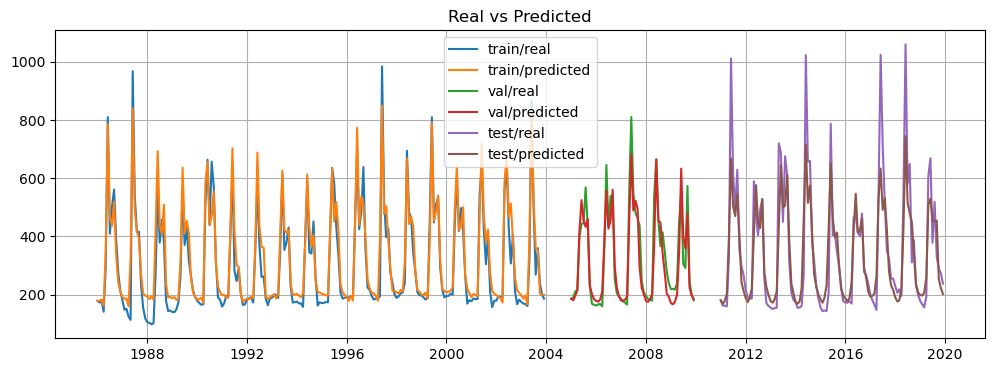

In [98]:
for part in split:
    if part in ("train", "val"):
        y_true, y_pred = forced_predict(model, split, part)

    if part == "test":
        y_true, y_pred = forced_predict(model, split, part)
        #y_pred = rolling_predict(model, split, part, forecast_horizon=len(y_true))

    split[part]["y_true"] = y_true
    split[part]["y_pred"] = y_pred

display_pred_with_rolling_test(split, show_only_target = True)

In [99]:
for part in split:
    part_rmse = mean_squared_error(
        y_true=split[part]["y_true"][:,0], y_pred=split[part]["y_pred"][:,0], squared=False
    )
    s_sigm =  S_sigma_delta(split[part]["y_true"][:,0], split[part]["y_pred"][:,0], delta_k = 1)
    print(f"{part:<5} S/sigma: {s_sigm:.2f}")
    print(f"{part:<5} RMSE: {part_rmse:.2f}")
    r2 = r2_score(y_true = split[part]["y_true"][:,0], y_pred = split[part]["y_pred"][:,0])
    print(f"{part:<5} R2: {r2:.2f} ")

train S/sigma: 0.32
train RMSE: 54.55
train R2: 0.90 
val   S/sigma: 0.41
val   RMSE: 58.80
val   R2: 0.87 
test  S/sigma: 0.48
test  RMSE: 99.54
test  R2: 0.79 


## 2.4 GRU

In [84]:

class TimeSeriesPredictorGRU(nn.Module):
    def __init__(self, input_size=8, hidden_size=50):
        # hidden_size it is number of hidden neurons
        super().__init__()
        self.rnn = nn.GRU(
            input_size=input_size, hidden_size=hidden_size, num_layers = 2,  batch_first=True
        )
        # Predict five values
        self.fc = nn.Linear(hidden_size, 8)

    def forward(self, x):
        # x shape: [b_s, seq_len, input_size]  b_s <= batch_size
        #print(self.rnn(x))
        out, h = self.rnn(x)  # [b_s, seq_len, hidden_size], [1, b_s, hidden_size]

        y = self.fc(h[-1])  # [1, b_s, 5]
        y = y.view(-1, 8)
        #y = y.flatten()  # [b_s]
        return y

In [85]:
model = TimeSeriesPredictorGRU()
out = model(x)

print(f"Model output size: {out.shape} (bach_size x out_dim)")

Model output size: torch.Size([16, 8]) (bach_size x out_dim)


In [86]:
L.seed_everything(42)

checkpoint_callback = ModelCheckpoint(
    monitor="MeanSquaredError/val", mode="min", filename="best"
)

exp_name = f"GRU_hydro_meteo"
trainer = Trainer(
    max_epochs=250,
    logger=TensorBoardLogger(save_dir=f"logs/time_series_prediction", name=exp_name),
    num_sanity_val_steps=1,
    callbacks=[checkpoint_callback],
    log_every_n_steps=5,
    enable_progress_bar=True,
)

model = TimeSeriesPredictorGRU()

pipeline = TimeSeriesPipeline(
    model=model,
    optimizer_class=torch.optim.Adam,
)

trainer.fit(
    model=pipeline,
    train_dataloaders=split["train"]["dataloader"],
    val_dataloaders=split["val"]["dataloader"],
)

Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type                   | Params | Mode 
-----------------------------------------------------------------
0 | model         | TimeSeriesPredictorGRU | 24.7 K | train
1 | criterion     | MSELoss                | 0      | train
2 | train_metrics | MetricCollection       | 0      | train
3 | valid_metrics | MetricCollection       | 0      | train
-----------------------------------------------------------------
24.7 K    Trainable params
0         Non-trainable params
24.7 K    Total params
0.099     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\black\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\Users\black\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=250` reached.


In [87]:
base_path = f"logs/time_series_prediction/{exp_name}"
last_version = sorted(os.listdir(base_path))[-1]
#last_version = 'version_12'
log_path = f"{base_path}/{last_version}"

ckpt_path = f"{log_path}/checkpoints/best.ckpt"
checkpoint = torch.load(ckpt_path)

print(f"Checkpoint has been loaded from {ckpt_path}")
print(f"Best model has been saved on the {checkpoint['epoch']} epoch")

state_dict = {}
for key in checkpoint["state_dict"].keys():
    key_new = key.lstrip("model.")
    state_dict[key_new] = checkpoint["state_dict"][key]

model = TimeSeriesPredictorGRU()

model.load_state_dict(state_dict)

Checkpoint has been loaded from logs/time_series_prediction/GRU_hydro_meteo/version_0/checkpoints/best.ckpt
Best model has been saved on the 65 epoch


C:\Users\black\AppData\Local\Temp\ipykernel_24628\4100623537.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path)


<All keys matched successfully>

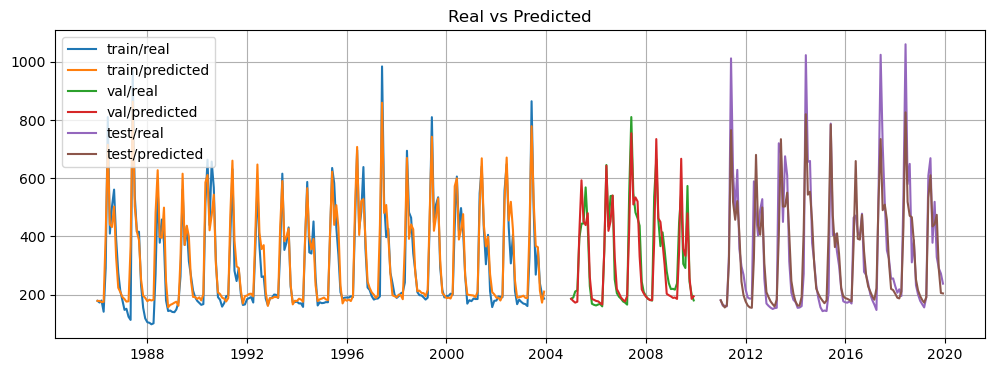

In [88]:
for part in split:
    if part in ("train", "val"):
        y_true, y_pred = forced_predict(model, split, part)

    if part == "test":
        y_true, y_pred = forced_predict(model, split, part)
        #y_pred = rolling_predict(model, split, part, forecast_horizon=len(y_true))

    split[part]["y_true"] = y_true
    split[part]["y_pred"] = y_pred

display_pred_with_rolling_test(split, show_only_target = True)

In [90]:
for part in split:
    part_rmse = mean_squared_error(
        y_true=split[part]["y_true"][:,0], y_pred=split[part]["y_pred"][:,0], squared=False
    )
    s_sigm =  S_sigma_delta(split[part]["y_true"][:,0], split[part]["y_pred"][:,0], delta_k = 1)
    print(f"{part:<5} S/sigma: {s_sigm:.2f}")
    print(f"{part:<5} RMSE: {part_rmse:.2f}")
    r2 = r2_score(y_true = split[part]["y_true"][:,0], y_pred = split[part]["y_pred"][:,0])
    print(f"{part:<5} R2: {r2:.2f} ")

train S/sigma: 0.33
train RMSE: 56.02
train R2: 0.89 
val   S/sigma: 0.39
val   RMSE: 56.19
val   R2: 0.88 
test  S/sigma: 0.44
test  RMSE: 91.75
test  R2: 0.82 


In [100]:
%load_ext tensorboard
%tensorboard --logdir logs/time_series_prediction --port 6008